# 1. Prepare the environment

In [19]:
# List all NVIDIA GPUs as available in this computer (or Colab's session)
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-47e5d942-9a60-fd83-07eb-a3f042f8546d)


In [2]:
import os
os.environ["PATH"] += os.pathsep + '/usr/local/bin'

import sys
print( f"Python {sys.version}\n" )

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib
import matplotlib.cm as cmp
import matplotlib.pyplot as plt
from IPython.display import Image, display
%matplotlib inline
print( f"Matplotlib {matplotlib.__version__}\n" )

import tensorflow as tf
from tensorflow.keras.utils import plot_model

print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

# add new 
# For image resizing
import cv2 as cv
print( f"OpenCV {cv.__version__}\n" )

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from PIL import Image

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

Python 3.10.14 (main, May  6 2024, 14:42:37) [Clang 14.0.6 ]

NumPy 1.26.4

Matplotlib 3.5.2

TensorFlow 2.16.1
tf.keras.backend.image_data_format() = channels_last
OpenCV 4.10.0

TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


In [30]:
# Set fixed seeding values for reproducability during experiments
# Skip this cell if random initialization (with varied results) is needed
np.random.seed(1234)
tf.random.set_seed(5678)

# 2. Load the pretrained model (only the feature extractor)

In [3]:
# For VGG-16, the default input_shape is 224x224x3
img_w,img_h = 224,224    
base_model = tf.keras.applications.vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (img_w, img_h, 3), classifier_activation=None)
base_model.summary()

2024-07-05 21:46:12.810854: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-07-05 21:46:12.810888: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-07-05 21:46:12.810895: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-07-05 21:46:12.810927: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-05 21:46:12.810949: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 2,359,808 (9.00 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

# 4. Custom ImageNet's decode_predictions

In [3]:
def my_imagenet_decode_predictions( preds, top=5 ):
    """
    This function is adapted from https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
    The adaptation is done so that ImageNet's class indices (0-999) are included in the function's outputs.

    Arguments:
        preds (numpy array): a batch of ImageNet's prediction outputs
        top (int): only decode 'top' classes with maximum scores

    Return a tuple of:
        Output[0]: a dict of { class_index:class_name } regarding the whole ImageNet dataset
        Output[1]: a 4D tuple of (class_index, class_name, class_description, score)
            Note that 'score' can be prediction values with or without the softmax activation, depending on the input 'preds'
    """
    if len(preds.shape) != 2 or preds.shape[1] != 1000:
        raise ValueError('`decode_predictions` expects '
                                 'a batch of predictions '
                                 '(i.e. a 2D array of shape (samples, 1000)). '
                                 'Found array with shape: ' + str(preds.shape))

    import json

    CLASS_INDEX_PATH = ('https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json')
    fpath = tf.keras.utils.get_file( 'imagenet_class_index.json',
                                                CLASS_INDEX_PATH,
                                                cache_subdir='models',
                                                file_hash='c2c37ea517e94d9795004a39431a14cb' )
    with open(fpath) as f:
        CLASS_INDEX = json.load(f)
        CLASS_INDEX = dict( zip( [ int(i) for i in CLASS_INDEX.keys() ], CLASS_INDEX.values() ) )

    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [ (i,) + tuple(CLASS_INDEX[i]) + (pred[i],) for i in top_indices ]
        result.sort(key=lambda x: x[-1], reverse=True)
        results.append(result)

    return CLASS_INDEX, results

In [174]:
# Load two test images from Internet
!wget "https://unionlakepetservices.com/wp-content/uploads/2019/03/baby-3858285_1280-1080x675.jpg"
!wget "https://keras.io/img/examples/vision/grad_cam/grad_cam_12_0.jpg"

zsh:1: command not found: wget
zsh:1: command not found: wget


# 3. Prepare our dataset

In [4]:
# Load CIFAR-10 color image dataset
#(x_train , y_train), (x_test , y_test) = tf.keras.datasets.cifar10.load_data()

train_dir = '/Users/Lemon/workspace/DL/HW/Datasets/Train'
val_dir = '/Users/Lemon/workspace/DL/HW/Datasets/Validation'#'/Users/wisa/Downloads/DADS/dataset/train'
#val_dir = '/Users/wisa/Downloads/DADS/dataset/validation'

# Create ImageDataGenerator instances

train_datagen = ImageDataGenerator(preprocessing_function=None)
validation_datagen = ImageDataGenerator(preprocessing_function=None)

# Flow data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Adjust to your image size
    batch_size=32,
    class_mode='categorical'  # Use 'categorical' for one-hot encoded labels
    #shuffle=True  # Ensure data is shuffled
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),  # Adjust to your image size
    batch_size=32,
    class_mode='categorical'  # Use 'categorical' for one-hot encoded labels
    #shuffle=True  # Ensure data is shuffled
)
# Inspect the dataset
##print( f"x_train: type={type(x_train)} , dtype={x_train.dtype} , shape={x_train.shape} , min={x_train.min(axis=None)} , max={x_train.max(axis=None)}" )
##print( f"y_train: type={type(y_train)} , dtype={y_train.dtype} , shape={y_train.shape} , min={min(y_train)} , max={max(y_train)}" )
#print( f"x_test: type={type(x_test)} , dtype={x_test.dtype} , shape={x_test.shape} , min={x_test.min(axis=None)} , max={x_test.max(axis=None)}"  )
#print( f"y_test: type={type(y_test)} , dtype={y_test.dtype} , shape={y_test.shape} , min={min(y_test)} , max={max(y_test)}" )

Found 302 images belonging to 4 classes.
Found 100 images belonging to 4 classes.


(32, 224, 224, 3) (32, 4)


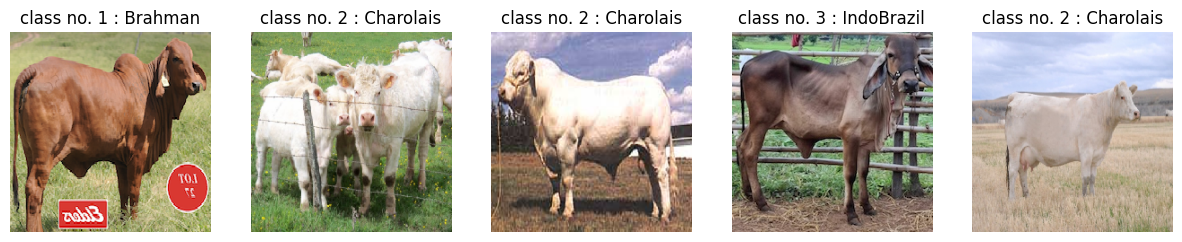

In [5]:
#cifar10_labels = [ 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck' ]
class_labels = ['Brahman', 'Charolais', 'IndoBrazil', 'Native']
# Visualize the first five images in the training data
x_batch, y_batch = next(train_generator)
print(x_batch.shape, y_batch.shape)

# Visualize the first five images in x_train
plt.figure(figsize=(15, 5))
for i in range(5):
    #plt.subplot(150 + 1 + i).set_title(f"class no. {y_batch[i].argmax()}: {class_labels[y_batch[i].argmax()]}")
    plt.subplot(150 + 1 + i).set_title(f"class no. {y_batch[i].argmax() + 1} : {class_labels[y_batch[i].argmax()]}")
    #plt.imshow(x_batch[i])
    plt.imshow( x_batch[i].astype(np.uint8))
    plt.axis("off")
plt.show()



In [6]:
# Preprocess CIFAR-10 dataset to match VGG-16's requirements

#x_train_vgg = tf.keras.applications.vgg16.preprocess_input(x_train)
#x_test_vgg = tf.keras.applications.vgg16.preprocess_input(x_test)

#print( x_train_vgg.dtype, x_train_vgg.shape, np.min(x_train_vgg), np.max(x_train_vgg) )
#print( x_test_vgg.dtype, x_test_vgg.shape, np.min(x_test_vgg), np.max(x_test_vgg) )

# Define a function to preprocess images
def preprocess_images(generator):
    for batch in generator:
        images, labels = batch
        preprocessed_images = preprocess_input(images)
        yield preprocessed_images, labels

# Apply preprocessing to the training and validation data generators
train_generator_vgg = preprocess_images(train_generator)
validation_generator_vgg = preprocess_images(validation_generator)

# Get a batch of preprocessed images to inspect
x_batch_vgg, y_batch_vgg = next(train_generator_vgg)
xx_batch_vgg, yy_batch_vgg = next(validation_generator_vgg)

print(x_batch_vgg.dtype, x_batch_vgg.shape, np.min(x_batch_vgg), np.max(x_batch_vgg))
print(y_batch_vgg.dtype, y_batch_vgg.shape, np.min(y_batch_vgg), np.max(y_batch_vgg))

print(xx_batch_vgg.dtype, xx_batch_vgg.shape, np.min(xx_batch_vgg), np.max(xx_batch_vgg))
print(yy_batch_vgg.dtype, yy_batch_vgg.shape, np.min(yy_batch_vgg), np.max(yy_batch_vgg))

float32 (32, 224, 224, 3) -123.68 151.061
float32 (32, 4) 0.0 1.0
float32 (32, 224, 224, 3) -123.68 151.061
float32 (32, 4) 0.0 1.0


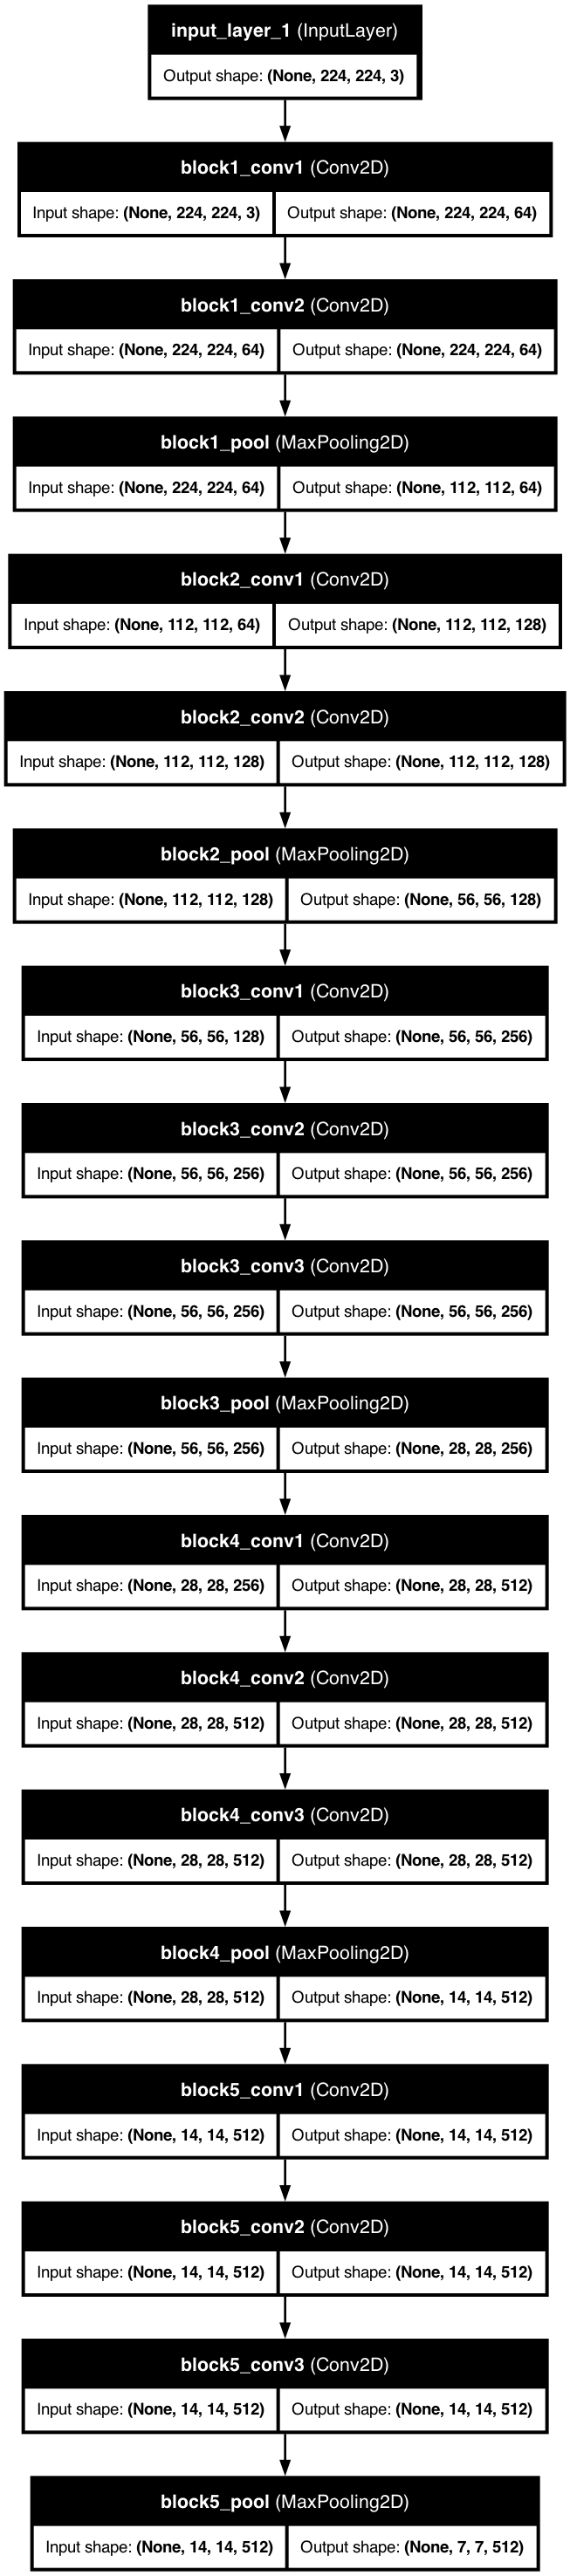

In [35]:
#tf.keras.utils.plot_model(vgg_extractor, to_file = 'VGG16_Model.png', show_shapes = True, show_dtype = False, show_layer_names = True, dpi = 96)
tf.keras.utils.plot_model(base_model, to_file='VGG16_Model.png', show_shapes=True, show_dtype=False, show_layer_names=True, dpi=96)

# 4. Prepare for transfer learning and finetuning

1. Add the new classification head
2. Decide whether to freeze or unfreeze any pretrained layers

## 4.1 Access and freeze layer(s) in Keras's model

In [7]:
#Recursively freeze all layers in the model first

# Access a layer by its 0-based index
a = base_model.layers[3]
print( f"Layer {a}: name = {a.name} , trainable = {a.trainable}" )
#a.trainable = False       # freeze this layer

# Access a layer by its name
b = base_model.get_layer('block5_conv1')
print( f"Layer {b}: name = {b.name} , trainable = {b.trainable}" )
b.trainable = False       # freeze this layer

Layer <MaxPooling2D name=block1_pool, built=True>: name = block1_pool , trainable = True
Layer <Conv2D name=block5_conv1, built=True>: name = block5_conv1 , trainable = True


In [8]:
# Iterate over all layers in the model
for i,layer in enumerate(base_model.layers):
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_layer , trainable = True
Layer 1: name = block1_conv1 , trainable = True
Layer 2: name = block1_conv2 , trainable = True
Layer 3: name = block1_pool , trainable = True
Layer 4: name = block2_conv1 , trainable = True
Layer 5: name = block2_conv2 , trainable = True
Layer 6: name = block2_pool , trainable = True
Layer 7: name = block3_conv1 , trainable = True
Layer 8: name = block3_conv2 , trainable = True
Layer 9: name = block3_conv3 , trainable = True
Layer 10: name = block3_pool , trainable = True
Layer 11: name = block4_conv1 , trainable = True
Layer 12: name = block4_conv2 , trainable = True
Layer 13: name = block4_conv3 , trainable = True
Layer 14: name = block4_pool , trainable = True
Layer 15: name = block5_conv1 , trainable = False
Layer 16: name = block5_conv2 , trainable = True
Layer 17: name = block5_conv3 , trainable = True
Layer 18: name = block5_pool , trainable = True


In [9]:
# Recursively freeze all layers in the model
base_model.trainable = False

for i,layer in enumerate(base_model.layers):
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_layer , trainable = False
Layer 1: name = block1_conv1 , trainable = False
Layer 2: name = block1_conv2 , trainable = False
Layer 3: name = block1_pool , trainable = False
Layer 4: name = block2_conv1 , trainable = False
Layer 5: name = block2_conv2 , trainable = False
Layer 6: name = block2_pool , trainable = False
Layer 7: name = block3_conv1 , trainable = False
Layer 8: name = block3_conv2 , trainable = False
Layer 9: name = block3_conv3 , trainable = False
Layer 10: name = block3_pool , trainable = False
Layer 11: name = block4_conv1 , trainable = False
Layer 12: name = block4_conv2 , trainable = False
Layer 13: name = block4_conv3 , trainable = False
Layer 14: name = block4_pool , trainable = False
Layer 15: name = block5_conv1 , trainable = False
Layer 16: name = block5_conv2 , trainable = False
Layer 17: name = block5_conv3 , trainable = False
Layer 18: name = block5_pool , trainable = False


In [10]:
#Access a layer by name
b = base_model.get_layer('block5_conv3')
print(f'Layer {b}: Name = {b.name}, Trainable = {b.trainable}')
b.trainable=True


Layer <Conv2D name=block5_conv3, built=True>: Name = block5_conv3, Trainable = False


In [11]:
# Fine-tuning by unfreezing layer  15 and 17 

for i, layer in enumerate(base_model.layers):
  print(f'Layer {i}: Name = {layer.name}, Trainable = {layer.trainable}')

Layer 0: Name = input_layer, Trainable = False
Layer 1: Name = block1_conv1, Trainable = False
Layer 2: Name = block1_conv2, Trainable = False
Layer 3: Name = block1_pool, Trainable = False
Layer 4: Name = block2_conv1, Trainable = False
Layer 5: Name = block2_conv2, Trainable = False
Layer 6: Name = block2_pool, Trainable = False
Layer 7: Name = block3_conv1, Trainable = False
Layer 8: Name = block3_conv2, Trainable = False
Layer 9: Name = block3_conv3, Trainable = False
Layer 10: Name = block3_pool, Trainable = False
Layer 11: Name = block4_conv1, Trainable = False
Layer 12: Name = block4_conv2, Trainable = False
Layer 13: Name = block4_conv3, Trainable = False
Layer 14: Name = block4_pool, Trainable = False
Layer 15: Name = block5_conv1, Trainable = False
Layer 16: Name = block5_conv2, Trainable = False
Layer 17: Name = block5_conv3, Trainable = True
Layer 18: Name = block5_pool, Trainable = False


# **Data Augmentation**

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        #rescale=1. / 255,
        #featurewise_center=True,             
        samplewise_center=True,             
        #featurewise_std_normalization=True,  
        samplewise_std_normalization=True,   
        #zca_whitening=False,                  
        rotation_range=0,                     
        width_shift_range=5.0,                
        height_shift_range=5.0,               
        zoom_range=0.2,
        horizontal_flip=True,                 
        vertical_flip=True,
        validation_split=0.3)

train_datagen.fit(train_generator)

In [ ]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        #rescale=1. / 255,
        # featurewise_center=True,             
        samplewise_center=True,             
        # featurewise_std_normalization=True,  
        samplewise_std_normalization=True
        )
test_datagen.fit(validation_generator_vgg)

In [ ]:
n_show = 1    # show 'n_show' batches of generated data (1 batch includes 5 images)

for b, (x_batch, y_batch) in enumerate( train_datagen.flow( x_batch_vgg, y_batch_vgg, batch_size=5, subset='training' ) ):
  print( f"===== Train batch no. {b+1}/{n_show} =====" )
  plt.figure(figsize=(15,5))
  for i in range(5):
      plt.subplot(150 + 1 + i).set_title( y_batch[i] )                
      plt.imshow( x_batch[i])
      plt.axis( "off" )        # remove all tick marks 
  plt.show()

  if b+1 >= n_show:
    break

In [ ]:
n_show = 1    # show 'n_show' batches of generated data (1 batch includes 5 images)

for b, (x_batch, y_batch) in enumerate( test_datagen.flow( xx_batch_vgg, yy_batch_vgg,batch_size=5 ) ):
  print( f"===== Train batch no. {b+1}/{n_show} =====" )
  plt.figure(figsize=(15,5))
  for i in range(5):
      plt.subplot(150 + 1 + i).set_title( y_batch[i] )                
      plt.imshow( x_batch[i])
      plt.axis( "off" )        # remove all tick marks 
  plt.show()

  if b+1 >= n_show:
    break

# **Train & Model Evaluate**

In [12]:
x = base_model.output

# Add our custom layer(s) to the end of the existing model
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)    #orgin
x = tf.keras.layers.Dense(256, activation = 'relu')(x)  #add
x = tf.keras.layers.Dense(128, activation = 'relu')(x)  #add
x = tf.keras.layers.Dense(64, activation = 'relu')(x)  #add

x = tf.keras.layers.Dropout(0.5)(x)
new_outputs = tf.keras.layers.Dense(4, activation="softmax")(x)

# Construct the main model
model = tf.keras.models.Model(inputs=base_model.inputs, outputs=new_outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             

 Total params: 27,732,996 (105.79 MB)

 Trainable params: 15,378,116 (58.66 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

In [14]:
print( model.layers[-1].activation )

<function softmax at 0x31ccfa790>


# Adapt the base model

# 5. Train the model with transfer learning

No finetuning is done in this example as all pretrained layers are freezed and only newly added layers are trained.

In [13]:
model.compile( loss="categorical_crossentropy", optimizer="adam", metrics=["acc"] )


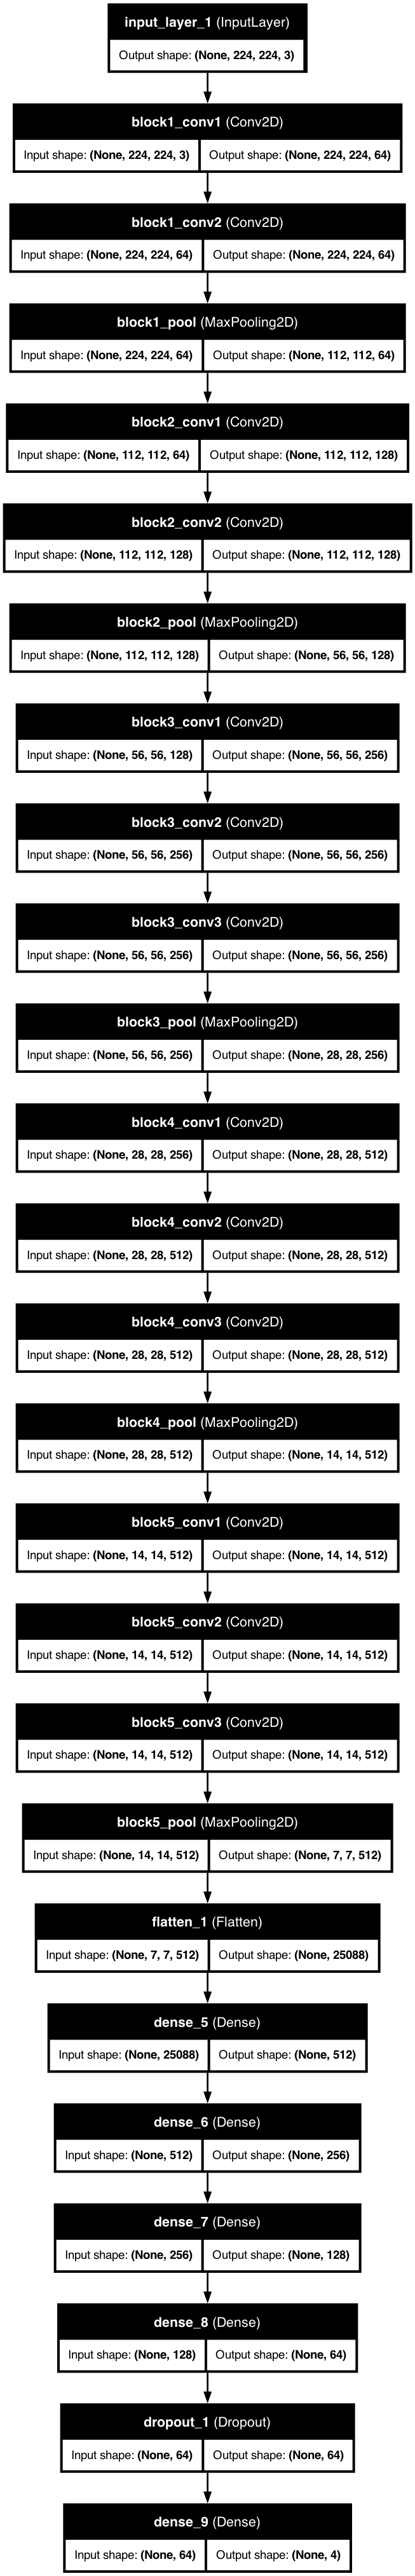

In [49]:
tf.keras.utils.plot_model(model, to_file = 'VGG16_Model.png', show_shapes = True, show_dtype = False, show_layer_names = True, dpi = 96)

In [14]:
#history = model.fit( x_train_vgg, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2 )

# Calculate steps per epoch
steps_per_epoch = max(1, train_generator.samples // train_generator.batch_size)
validation_steps = max(1, validation_generator.samples // validation_generator.batch_size)

print(f"Total training samples: {train_generator.samples}")
print(f"Total validation samples: {validation_generator.samples}")
print(f'Steps per epoch: {steps_per_epoch}, Validation steps: {validation_steps}')

# Fit the model
history = model.fit(
    train_generator_vgg,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    verbose=1,
    validation_data=validation_generator_vgg,
    validation_steps=validation_steps
)


Total training samples: 302
Total validation samples: 100
Steps per epoch: 9, Validation steps: 3
Epoch 1/10


2024-07-05 21:47:51.284837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 623ms/step - acc: 0.2795 - loss: 23.0373 - val_acc: 0.4118 - val_loss: 1.5260
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 581ms/step - acc: 0.4852 - loss: 2.1371 - val_acc: 0.6042 - val_loss: 0.9123
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 566ms/step - acc: 0.6776 - loss: 0.9082 - val_acc: 0.7353 - val_loss: 0.7359
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 562ms/step - acc: 0.7655 - loss: 0.6877 - val_acc: 0.7500 - val_loss: 0.6457
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 535ms/step - acc: 0.8462 - loss: 0.3728 - val_acc: 0.7794 - val_loss: 0.7475
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 578ms/step - acc: 0.8571 - loss: 0.4817 - val_acc: 0.7708 - val_loss: 0.7015
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 534ms/step - acc: 0.8858 - loss: 0.3159 - val_acc: 0.7353 - val_loss: 0.8191
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 535ms/step - acc: 0.8961 - loss: 0.3252 - val_acc: 0.8235 - val_loss: 0.5047
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 544ms/step - acc: 0.9090 - loss: 0.2708 - v

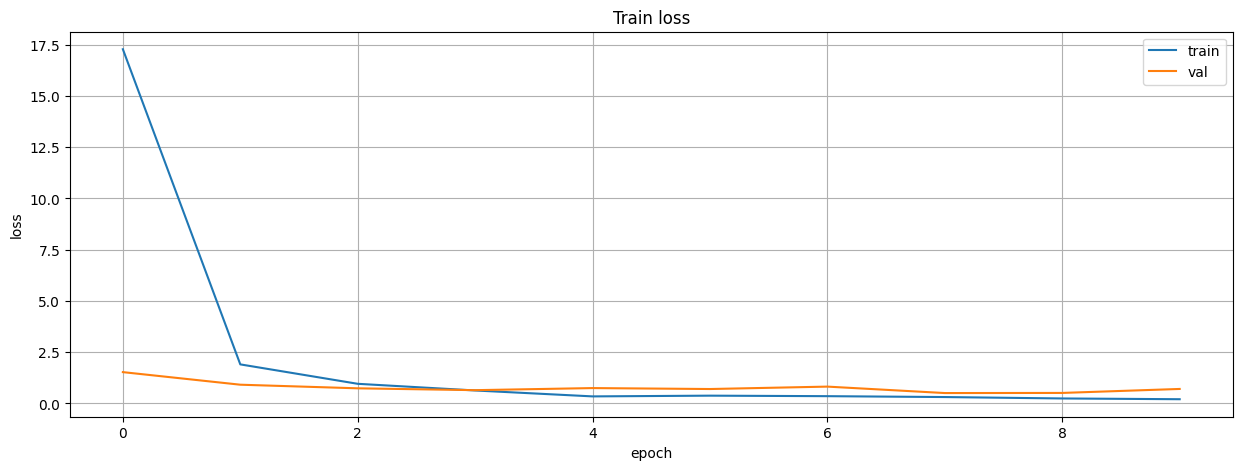

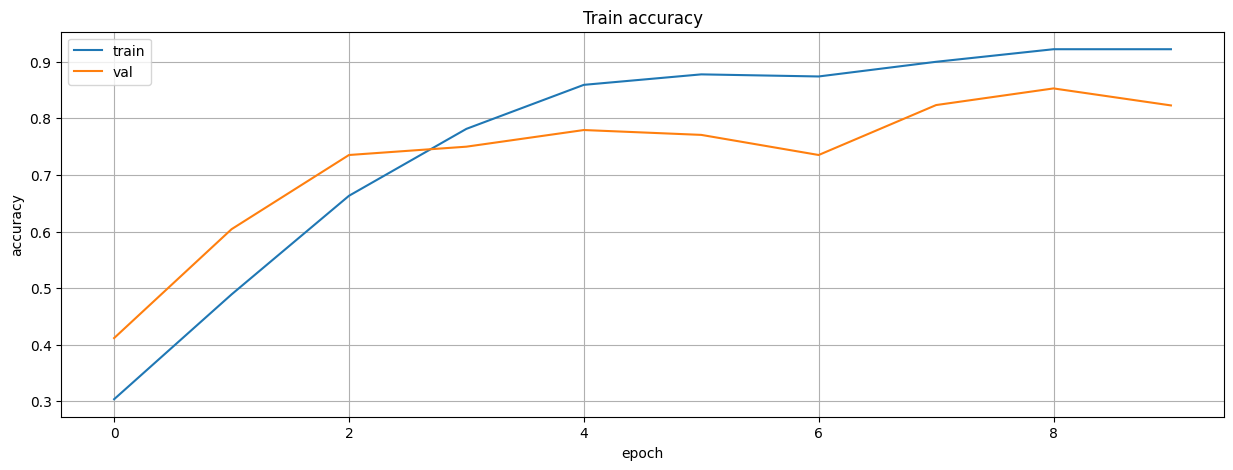

In [15]:
# Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid()
plt.show()

# Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

# Evaluate the model on test set

In [16]:
# Evaluate the trained model on the test set
results = model.evaluate(xx_batch_vgg, yy_batch_vgg, batch_size=8)
print( f"{model.metrics_names}: {results}" )

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - acc: 0.8417 - loss: 0.7878
['loss', 'compile_metrics']: [0.8919070959091187, 0.84375]


In [272]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
y_pred = []
for i in range(len(xx_batch_vgg)):
  x_input = xx_batch_vgg[i][np.newaxis, ...]
  y_pred.append(np.argmax(model.predict(x_input)))
cm = confusion_matrix(yy_batch_vgg, y_pred)
ax = sns.heatmap(cm, annot = True, xticklabels = class_labels, yticklabels = class_labels, linewidth=.5, )
ax.set(xlabel='Predict',ylabel='Actual')

ModuleNotFoundError: No module named 'seaborn'

In [17]:
# (Optional) Codes for coloring frames of the predicted images
plt.rcParams["axes.linewidth"] = 5

def color_frame(ax, true_label, pred_label):
    if true_label == pred_label:
        color = 'green'
    else:
        color = 'red'
    for spine in ax.spines.values():
        spine.set_edgecolor(color)
        spine.set_linewidth(5)

samples.shape=(10, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


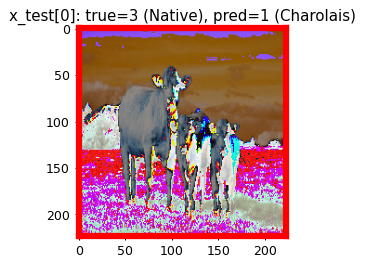

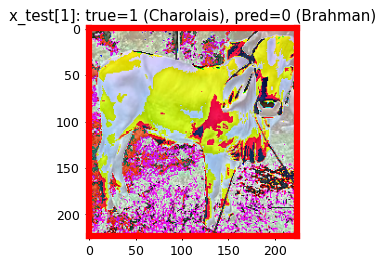

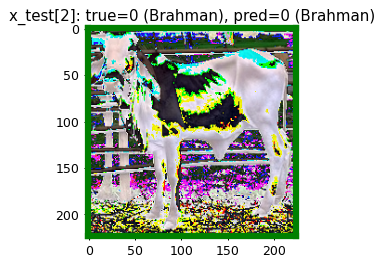

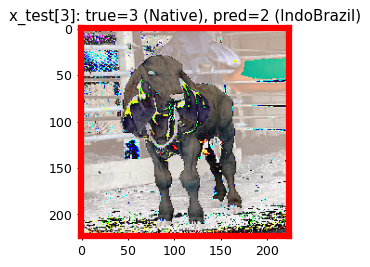

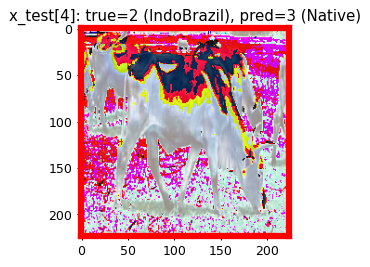

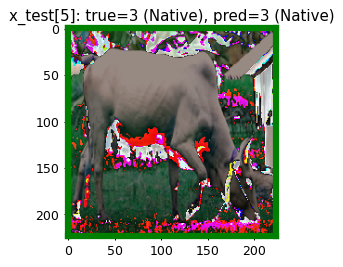

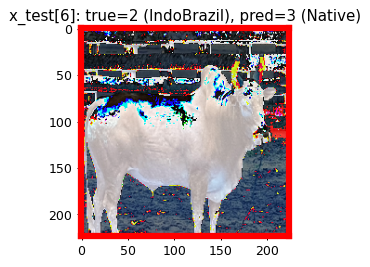

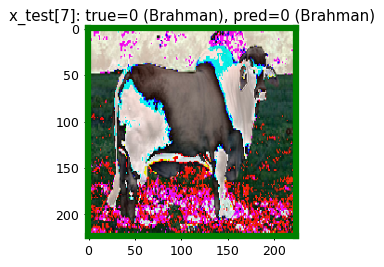

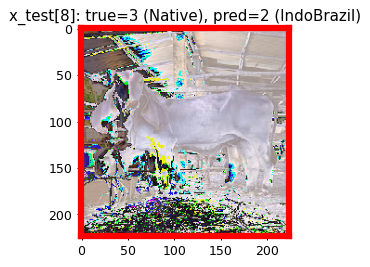

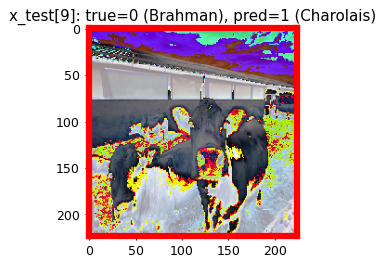

In [18]:
n = 10
samples = xx_batch_vgg[:n]
print(f'{samples.shape=}')

y_pred = model.predict(samples)

for i in range(n):
  plt.figure(figsize=(3, 3), dpi=90)
  ax = plt.gca()
  # y_pred = model.predict(x_test_vgg16[i].reshape(1,224,224,3))
  #plt.imshow(x_test[i])
  #plt.imshow(samples[i])
  plt.imshow(samples[i].astype(np.uint8))
  true_label = int(np.argmax(y_batch_vgg[i]))
  pred_label = int(np.argmax(y_pred[i]))
  plt.title(f"x_test[{i}]: true={true_label} ({class_labels[true_label]}), pred={pred_label} ({class_labels[pred_label]})")
  #plt.title(f'x_test[{i}]: predict = {np.argmax(y_pred)} ({class_labels[np.argmax(y_pred)]}) , actual = {y_test[i]} ({class_labels[int(y_test[i])]})')
  color_frame(ax, true_label, pred_label)
  plt.show()


# **Grad-CAM**

In [19]:
img_size = (224, 224)
preprocess_input = tf.keras.applications.vgg16.preprocess_input
#last_conv_layer_name = "block5_conv3" # This is for VGG-16
last_conv_layer_name = "block5_conv3" # This is for VGG-16


In [23]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
          last_conv_layer_output, preds = grad_model(img_array)
          if pred_index is None:
              pred_index = tf.argmax(preds[0])
          class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
    
def save_and_display_gradcam(img_path, heatmap, cam_path="cam_vgg.jpg", alpha=0.8):
      img = img_path

      # Rescale heatmap to a range 0-255
      heatmap = np.uint8(255 * heatmap)

      # Use jet colormap to colorize heatmap
      jet = plt.get_cmap("jet")

      # Use RGB values of the colormap
      jet_colors = jet(np.arange(256))[:, :3]
      jet_heatmap = jet_colors[heatmap]

      # Create an image with RGB colorized heatmap
      jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
      jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
      jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

      # Superimpose the heatmap on original image
      superimposed_img = jet_heatmap * alpha + img
      superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

      # Save the superimposed image
      superimposed_img.save(cam_path)
      display(Image('cam_vgg.jpg'))

      # Display Grad CAM
      #display(Image(plt.imshow(superimposed_img)[0]))

# 7. Inference

In [24]:
# (Optional) Codes for coloring frames of the predicted images
plt.rcParams["axes.linewidth"] = 5

def color_frame(ax, true_label, pred_label):
    if true_label == pred_label:
        color = 'green'
    else:
        color = 'red'
    for spine in ax.spines.values():
        spine.set_edgecolor(color)
        spine.set_linewidth(5)


samples.shape=(5, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


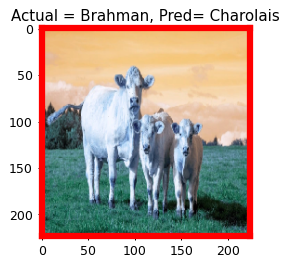

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Actual = Brahman, Pred= Charolais


TypeError: 'module' object is not callable

In [25]:
# Test using the model on many images witth Grad Cam
preprocess_input = tf.keras.applications.vgg16.preprocess_input

# Get a batch of samples
n = 5
samples = xx_batch_vgg[:n]
print(f'{samples.shape=}')

# Predict a batch of samples
y_pred = model.predict(samples)

# Interpret the results
for i in range(n):
    plt.figure(figsize=(3, 3), dpi=90)
    ax = plt.gca() 
    show_img = tf.keras.preprocessing.image.array_to_img(samples[i])   
    plt.imshow(show_img)
    true_label = int(np.argmax(y_batch[i]))
    pred_label = int(np.argmax(y_pred[i]))
    plt.title(f"Actual = {class_labels[true_label]}, Pred= {class_labels[pred_label]}")
    color_frame(ax, true_label, pred_label)
    plt.show()
    #c= np.random.randint(0,16)
    img_path = samples[i]
    img_array = preprocess_input(img_path)
    model.layers[-1].activation = None
    preds = model.predict(img_array.reshape(-1,224,224,3))
    true_label = int(np.argmax(y_batch[i]))
    pred_label = int(np.argmax(y_pred[i]))
    #plt.title(f"Actual = {labels[true_label]}, Pred= {labels[pred_label]}")
    #print(f"Predicted: {labels[np.argmax(preds)]} | Actual: {labels[y_batch_t[c]]} ")
    print(f'Actual = {class_labels[true_label]}, Pred= {class_labels[pred_label]}')
    heatmap = make_gradcam_heatmap(img_array.reshape(1,224,224,3), model, last_conv_layer_name)
    save_and_display_gradcam(img_path, heatmap)

    

samples.shape=(15, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


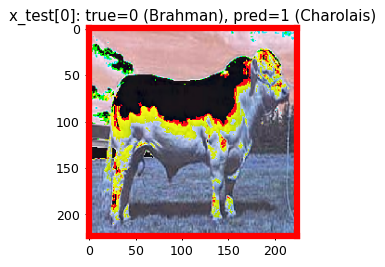

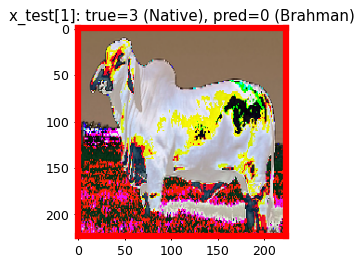

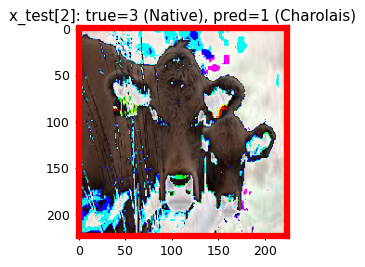

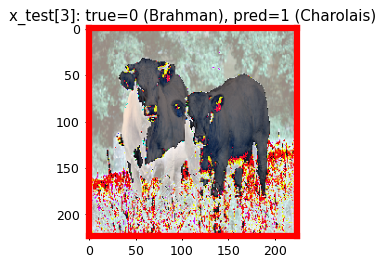

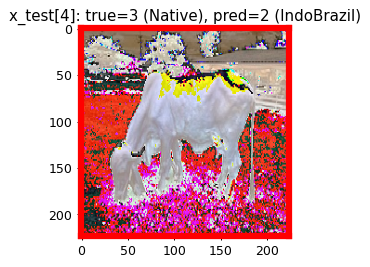

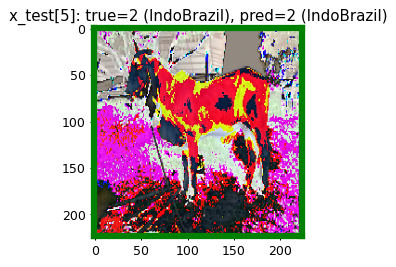

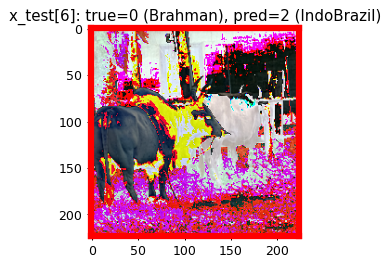

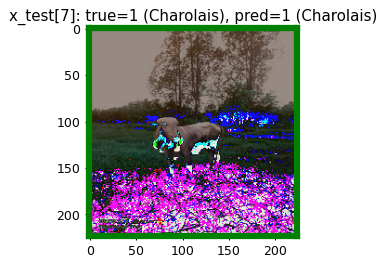

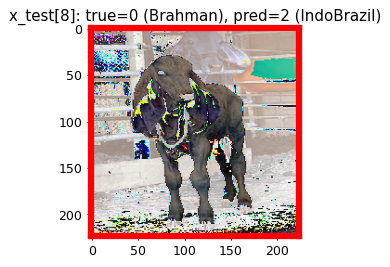

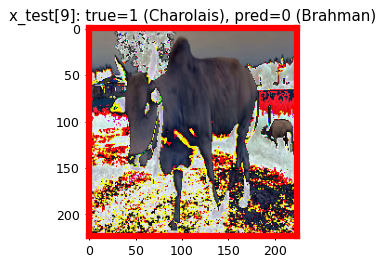

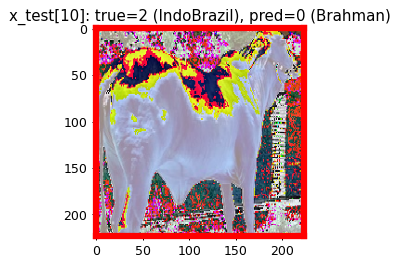

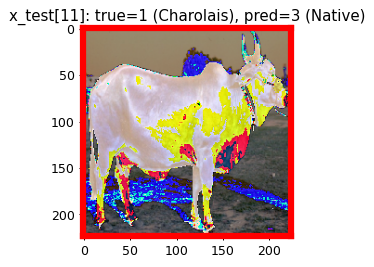

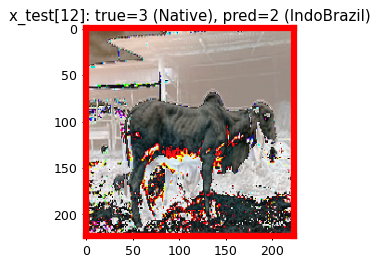

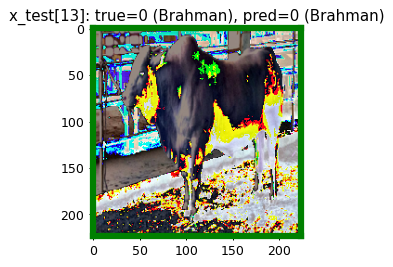

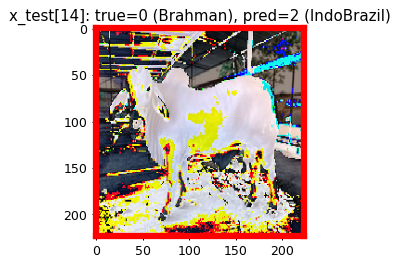

In [23]:
# Test using the model on many images

# Get a batch of samples
n = 15
samples = xx_batch_vgg[:n]
print(f'{samples.shape=}')

# Predict a batch of samples
y_pred = model.predict(samples)

# Interpret the results
for i in range(n):
    plt.figure(figsize=(3, 3), dpi=90)
    ax = plt.gca()
    #plt.imshow(samples[i])
    plt.imshow(samples[i].astype(np.uint8))
    true_label = int(np.argmax(y_batch_vgg[i]))
    pred_label = int(np.argmax(y_pred[i]))
    plt.title(f"x_test[{i}]: true={true_label} ({class_labels[true_label]}), pred={pred_label} ({class_labels[pred_label]})")
    color_frame(ax, true_label, pred_label)
    plt.show()

    